In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

# Tắt các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

# Cài đặt để Matplotlib hiển thị biểu đồ ngay trong notebook
%matplotlib inline

In [7]:
# --- Bước 1: Tải và Khám phá Dữ liệu ---
print("--- Bước 1: Tải và Khám phá Dữ liệu ---")
try:
    data = pd.read_csv('./data/diabetes_prediction_dataset.csv')
    print("Tải dữ liệu 'diabetes_prediction_dataset.csv' thành công!")
    
    print("\n5 dòng dữ liệu đầu tiên:")
    display(data.head())
    
    print("\nThông tin chung về dữ liệu:")
    data.info()
    
    print("\nKiểm tra các giá trị của cột 'smoking_history':")
    print(data['smoking_history'].value_counts())
    
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp 'diabetes_prediction_dataset.csv'.")

--- Bước 1: Tải và Khám phá Dữ liệu ---
Tải dữ liệu 'diabetes_prediction_dataset.csv' thành công!

5 dòng dữ liệu đầu tiên:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Kiểm tra các giá trị của cột 'smoking_history':
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


In [9]:
# --- Bước 2: Tiền xử lý dữ liệu ---
print("Đang tiến hành tiền xử lý...")

# Sao chép dữ liệu để xử lý
data_processed = data.copy()

# Mã hóa các biến phân loại (Encoding Categorical Variables)
# Sử dụng pd.get_dummies để chuyển đổi 'gender' và 'smoking_history'
# drop_first=True để tránh bẫy biến giả (dummy variable trap)
categorical_cols = ['gender', 'smoking_history']
data_processed = pd.get_dummies(data_processed, columns=categorical_cols, drop_first=True)

print("Tiền xử lý dữ liệu thành công.")
print("Dữ liệu sau khi xử lý (5 dòng đầu):")
display(data_processed.head())

print("\nCác cột mới sau khi mã hóa:")
print(data_processed.columns)

Đang tiến hành tiền xử lý...
Tiền xử lý dữ liệu thành công.
Dữ liệu sau khi xử lý (5 dòng đầu):


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False



Các cột mới sau khi mã hóa:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')


In [11]:
# --- Bước 3: Chuẩn bị dữ liệu cho tập Train và Test ---
print("\n--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---")

# Tách X (đặc trưng) và y (mục tiêu)
X = data_processed.drop('diabetes', axis=1)
y = data_processed['diabetes']

# Lấy tên các đặc trưng để sử dụng sau này
feature_names = X.columns.tolist() 

# Chia dữ liệu (tương tự Nhiệm vụ 1, bước 3 trong tài liệu)
# Tỷ lệ 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")


--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---
Kích thước tập huấn luyện (X_train): (80000, 13)
Kích thước tập kiểm tra (X_test): (20000, 13)



--- Nhiệm vụ A: Xây dựng Cây quyết định ---
Độ chính xác (Accuracy) của Cây quyết định: 0.9721

Đang vẽ cây quyết định...


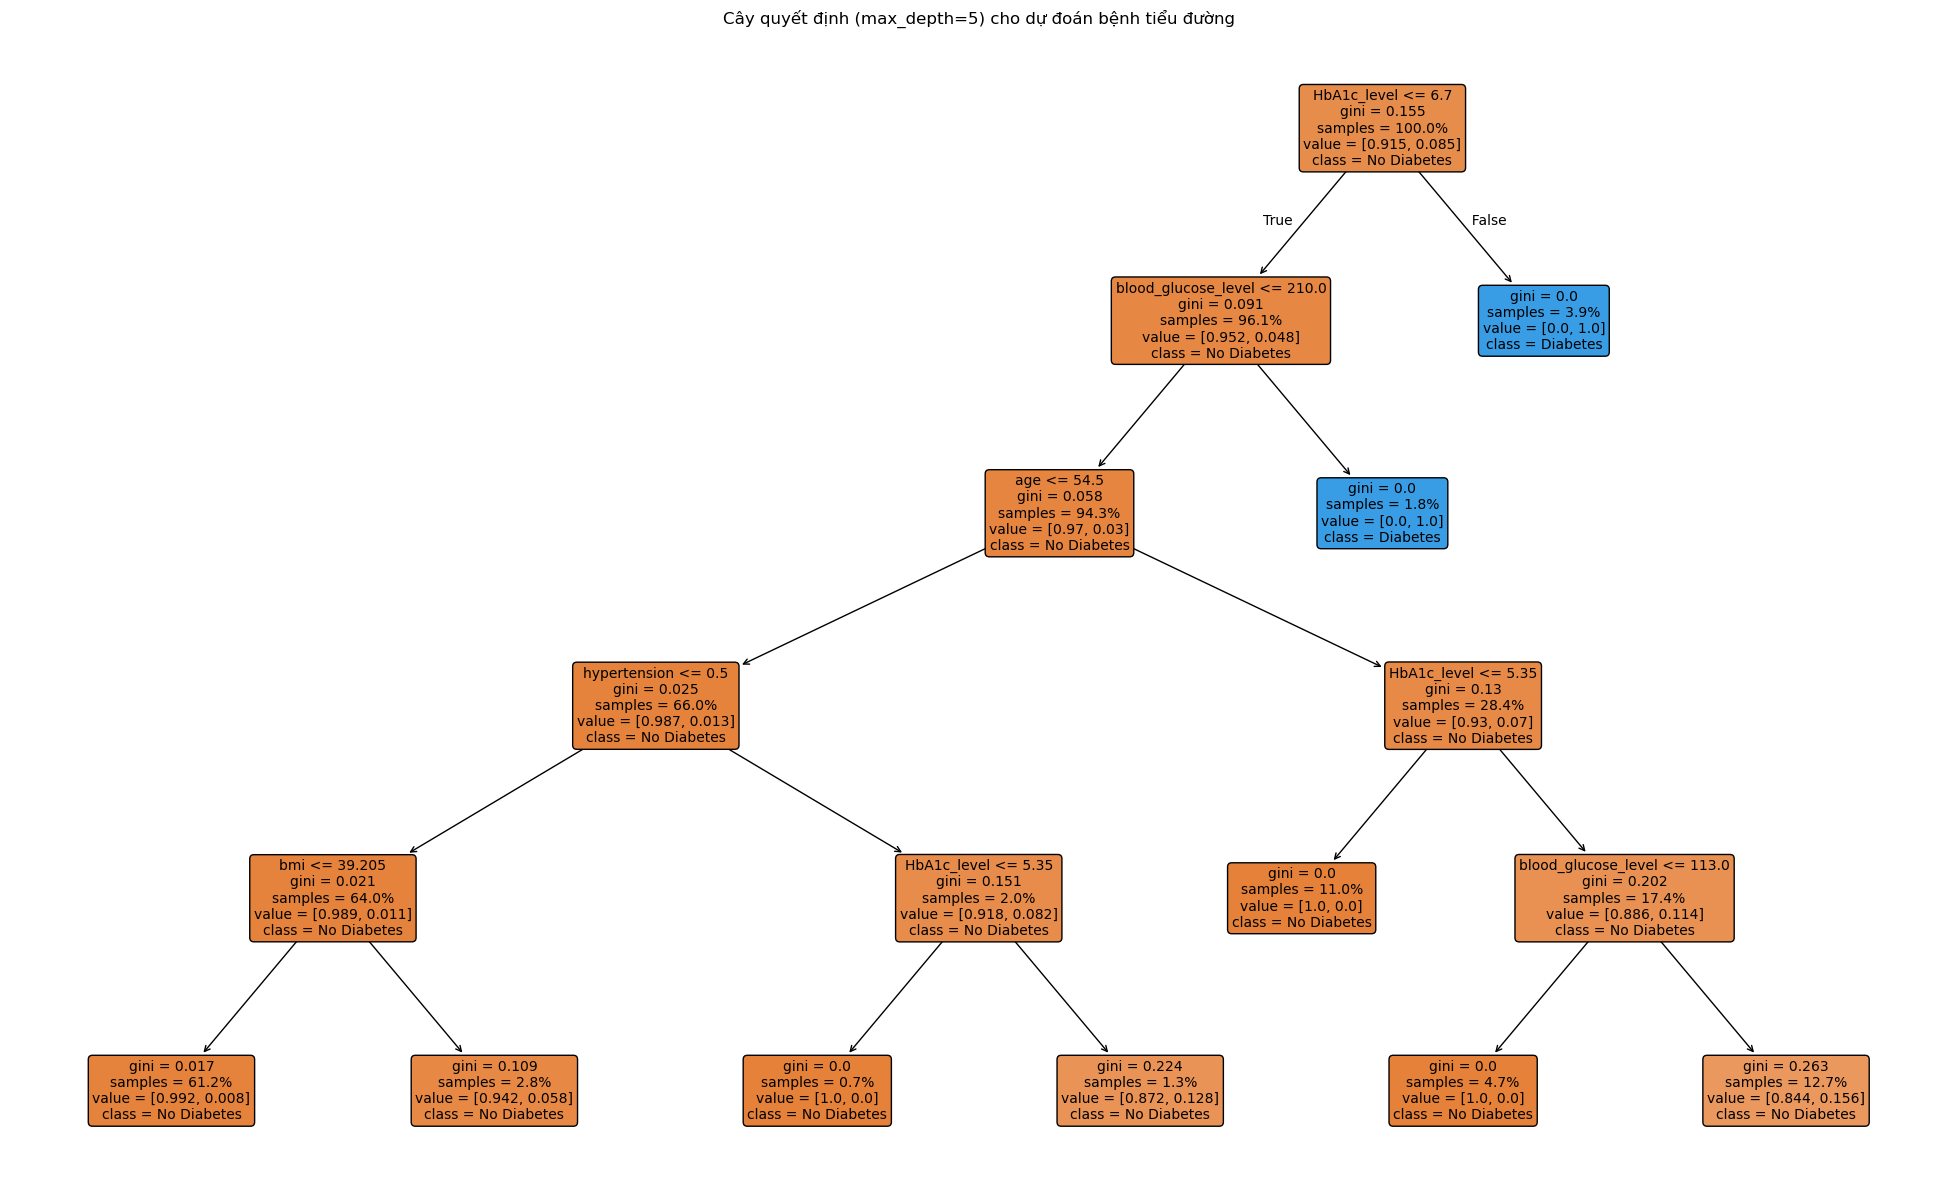

In [13]:
# --- Nhiệm vụ A: Xây dựng Cây quyết định (Decision Tree) ---
print("\n--- Nhiệm vụ A: Xây dựng Cây quyết định ---")

# 1. Xây dựng cây với độ sâu giới hạn (max_depth=5) để dễ quan sát
# (Giống Nhiệm vụ 1, bước 4 trong tài liệu)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# 2. Đánh giá mô hình
y_pred_dt = dt_model.predict(X_test)
print(f"Độ chính xác (Accuracy) của Cây quyết định: {accuracy_score(y_test, y_pred_dt):.4f}")

# 3. Hiển thị cây quyết định (sử dụng plot_tree của Scikit-learn)
print("\nĐang vẽ cây quyết định...")
plt.figure(figsize=(25, 15)) # Kích thước lớn để dễ đọc

plot_tree(dt_model, 
          feature_names=feature_names, 
          class_names=['No Diabetes', 'Diabetes'],
          filled=True,     
          rounded=True,    
          proportion=True, 
          fontsize=10)     

plt.title("Cây quyết định (max_depth=5) cho dự đoán bệnh tiểu đường")
plt.savefig("diabetes_decision_tree.png")
plt.show()

In [15]:
# --- Nhiệm vụ B: Xây dựng Rừng cây (Random Forest) và Tối ưu hóa (GridSearchCV) ---
print("\n--- Nhiệm vụ B: Xây dựng Rừng cây & Tối ưu hóa ---")

# 1. Tạo mô hình (Giống Nhiệm vụ 3, bước 2)
rf_model = RandomForestClassifier(random_state=42)

# 2. Định nghĩa các tham số để tối ưu (GridSearchCV)
# Chú ý: Vì bộ dữ liệu lớn (100k dòng), việc chạy GridSearchCV sẽ mất thời gian.
# Chúng ta sẽ dùng các giá trị nhỏ để chạy nhanh hơn.
# (Giống Nhiệm vụ 2, bước 2 trong tài liệu)
params_grid = {
    'n_estimators': [50, 100],      # Số lượng cây
    'max_depth': [5, 10]            # Độ sâu tối đa
}

# 3. Sử dụng GridSearchCV (Giống Nhiệm vụ 2, bước 2)
# cv=3 (3-fold cross-validation) để chạy nhanh hơn
grid_search_rf = GridSearchCV(estimator=rf_model, 
                            param_grid=params_grid, 
                            cv=3, 
                            scoring='accuracy', 
                            verbose=2,  # Hiển thị log
                            n_jobs=-1)  # Sử dụng tất cả CPU

print("Bắt đầu huấn luyện GridSearchCV (việc này có thể mất vài phút)...")
grid_search_rf.fit(X_train, y_train)
print("Huấn luyện GridSearchCV hoàn tất.")

# 4. In ra tham số tốt nhất
print(f"\nTham số Rừng cây tốt nhất tìm được: {grid_search_rf.best_params_}")
print(f"Độ chính xác tốt nhất trên tập huấn luyện (CV score): {grid_search_rf.best_score_:.4f}")


--- Nhiệm vụ B: Xây dựng Rừng cây & Tối ưu hóa ---
Bắt đầu huấn luyện GridSearchCV (việc này có thể mất vài phút)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Huấn luyện GridSearchCV hoàn tất.

Tham số Rừng cây tốt nhất tìm được: {'max_depth': 5, 'n_estimators': 50}
Độ chính xác tốt nhất trên tập huấn luyện (CV score): 0.9718



--- Đánh giá mô hình tốt nhất trên tập Test ---
Độ chính xác (Accuracy) của Rừng cây tốt nhất trên tập Test: 0.9721

Báo cáo phân loại (Classification Report) của Rừng cây:
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.99     18292
    Diabetes       1.00      0.67      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


--- Phân tích mức độ quan trọng của đặc trưng ---


,Importance
HbA1c_level,5.360236e-01
blood_glucose_level,3.670262e-01
age,3.550836e-02
bmi,2.483265e-02
hypertension,1.976395e-02
heart_disease,1.350755e-02
smoking_history_former,2.353005e-03
gender_Male,4.590371e-04
smoking_history_never,3.043951e-04
smoking_history_ever,9.509807e-05


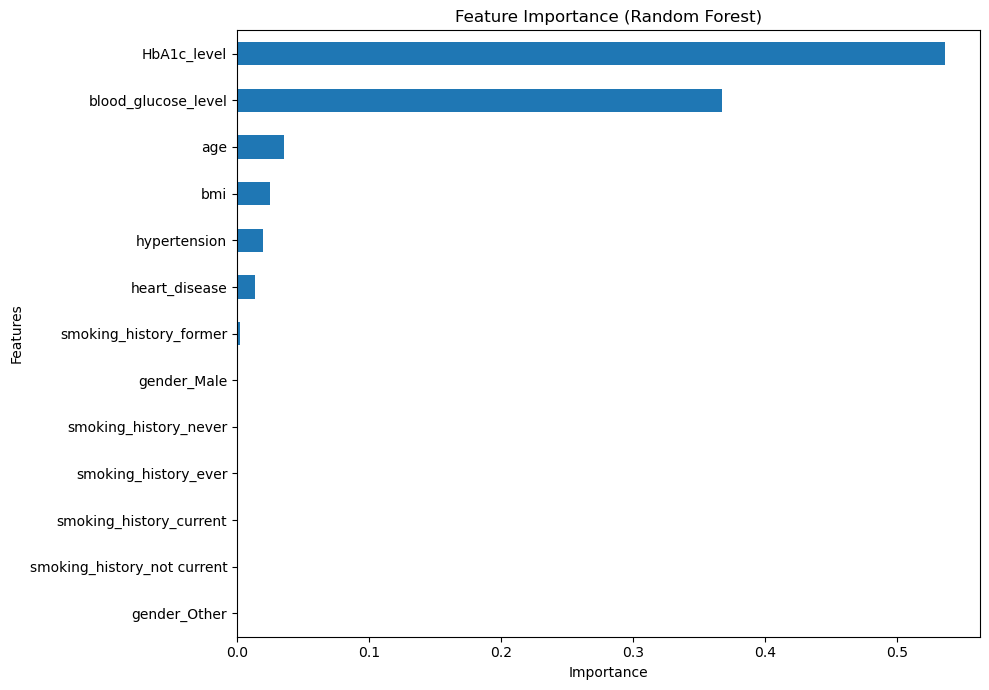

In [17]:
# --- Đánh giá cuối cùng & Mức độ quan trọng của Đặc trưng ---
print("\n--- Đánh giá mô hình tốt nhất trên tập Test ---")

# 1. Lấy mô hình tốt nhất từ GridSearchCV
best_rf = grid_search_rf.best_estimator_

# 2. Đánh giá trên tập test
y_pred_rf = best_rf.predict(X_test)
print(f"Độ chính xác (Accuracy) của Rừng cây tốt nhất trên tập Test: {accuracy_score(y_test, y_pred_rf):.4f}")

print("\nBáo cáo phân loại (Classification Report) của Rừng cây:")
print(classification_report(y_test, y_pred_rf, target_names=['No Diabetes', 'Diabetes']))

# 3. Phân tích Mức độ quan trọng của Đặc trưng (Giống Hình 2.4)
print("\n--- Phân tích mức độ quan trọng của đặc trưng ---")
feat_imp_df = pd.DataFrame({
    'Importance': best_rf.feature_importances_},
    index=feature_names
)

# Sắp xếp và vẽ biểu đồ
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
display(feat_imp_df)

plt.figure(figsize=(10, 7))
feat_imp_df.sort_values('Importance', ascending=True).plot(kind='barh', legend=False, ax=plt.gca())
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('diabetes_feature_importance.png')
plt.show()